# Examine the dynamics of viral escape from each antibody

## Import Python modules

In [18]:
import os
import sys
import glob
import random
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(font_scale=1.0, style='ticks', palette='colorblind')

import scipy.stats
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform, pdist, cdist
#import hdbscan
#import umap

#from Bio import SeqIO
import dmslogo

# Import custom script
sys.path.append('../scripts/')
import clusters

## Read in data

Read in escape scores and DMS data

In [19]:
# Read in amino-acid level DMS data from Cao et al. and make a shorter
# dataframe giving the epitope group of each ab
dms_df = pd.read_csv('../convergent_RBD_evolution/use_res_clean.csv')
ab_group_df = (
    dms_df
    .drop_duplicates('antibody')[['antibody', 'group']]
    .rename(columns={'group' : 'epitope_cluster'})
)

# Read in site-level escape scores
escape_calc_resultsdir = '../results/processed_input_data/'
site_escape_df = pd.read_csv(os.path.join(escape_calc_resultsdir, 'escape.csv'))

# Read in estimated escape scores for antibodies from Cao et al. and merge with data
# giving epitope groups
escape_scores_df = pd.read_csv('../results/predicted_escape_scores/all_predictions.csv')
escape_scores_df = escape_scores_df.merge(ab_group_df, how='left')
escape_scores_df['epitope_cluster'].fillna('other', inplace=True)
escape_scores_df['escape_score'].clip(upper=1.0, inplace=True)
escape_scores_df['all_aa_substitutions'] = escape_scores_df['all_aa_substitutions'].fillna('')

# Rename some of the Nextstrain clade names, and consolidate the Delta clades into one
escape_scores_df['clade'] = escape_scores_df['Nextstrain_clade']
escape_scores_df['clade'] = escape_scores_df['clade'].replace({
    '20E (EU1)' : '20E',
    '20H (Beta, V2)' : '20H (Beta)',
    '20I (Alpha, V1)' : '20I (Alpha)',
    '20J (Gamma, V3)' : '20J (Gamma)',
    '21K (Omicron)' : '21K (BA.1)',
    '21L (Omicron)' : '21L (BA.2)',
    '22A (Omicron)' : '22A (BA.4)',
    '22B (Omicron)' : '22B (BA.5)',
    '22C (Omicron)' : '22C (BA.2.12.1)',
    '22D (Omicron)' : '22D (BA.2.75)',
    '22E (Omicron)' : '22E (BQ.1)',
    '22F (Omicron)' : '22F (XBB)',
    '23A (Omicron)' : '23A (XBB.1.5)',
    '23B (Omicron)' : '23B (XBB.1.16)',
    '23D (Omicron)' : '23D (XBB.1.9)',
    '23E (Omicron)' : '23E (XBB.2.3)',

    # '21A (Delta)' : '21A/I/J (Delta)',
    # '21I (Delta)' : '21A/I/J (Delta)',
    # '21J (Delta)' : '21A/I/J (Delta)',
})
escape_scores_df['clade3'] = escape_scores_df['clade'].apply(lambda x: x[:3])

abs_with_predictions = escape_scores_df["antibody"].unique()
print(f'Read in predicted escape scores for {len(abs_with_predictions)} antibodies')

Read in predicted escape scores for 1609 antibodies


Read in estimated fitness effects of amino-acid mutations.

In [20]:
# Read in data
f = '/fh/fast/matsen_e/hhaddox/2024/SARS2-synonymous-mut-rate/SARS2-mut-fitness/results_gisaid_2024-04-24/aa_fitness/aamut_fitness_by_clade.csv'
fitness_df = pd.read_csv(f)

# Consolidate the Delta clades using the same strategy as in the dataframe of escape scores
# fitness_df['clade'] = fitness_df['clade'].replace({
#     #'21A' : '21A',
#     '21I' : '21A',
#     '21J' : '21A',
# })
# fitness_df = fitness_df.groupby(['clade', 'gene', 'aa_mutation'], as_index=False).agg(
#     delta_fitness = pd.NamedAgg('delta_fitness', 'mean'),
#     actual_count = pd.NamedAgg('actual_count', 'sum'),
#     expected_count = pd.NamedAgg('expected_count', 'sum'),
# )

# Merge with clade names in the dataframe of escape scores
fitness_df.rename(columns={'clade':'clade3'}, inplace=True)
clade3_df = escape_scores_df.drop_duplicates('clade')[['clade', 'clade3']]
fitness_df = fitness_df.merge(clade3_df, on='clade3', how='left')

Read in IC50 data

In [21]:
# Read in IC50 data from Cao et al.
ic50s_df = pd.read_csv(os.path.join(
    escape_calc_resultsdir, 'antibody_IC50s.csv'
))
ic50s_df['study'] = 'Cao et al.'

# Read in IC50 data from Wang et al.
cols = [
    'antibody', 'Spike', 'RBD', 'NTD',
    'av_D614G', 'av_Beta', 'av_Gamma', 'av_Delta', 'av_Omicron',
    'pv_D614G', 'pv_Alpha', 'pv_Beta', 'pv_Gamma', 'pv_Delta',
    'pv_Lamda', 'pv_Omicron',
    'BLI'
]
wang_ic50s_df = pd.read_excel('../data/Wang_ic50_values.xlsx', skiprows=3, names=cols)
wang_ic50s_df = (
    wang_ic50s_df[
        (wang_ic50s_df['antibody'].str.contains('data referenced') == False)
    ]
    .dropna(subset='antibody')
    .replace('>50', '50')
    .replace('>10', 10)
    .replace('NS', np.nan)
    .replace('-', np.nan)
)
wang_ic50s_df['antibody'] = wang_ic50s_df['antibody'].apply(
    lambda x: x.replace('*', '').replace('XGv', 'XGv-')
)

# For Wang et al., record IC50s for both authentic virus (av) and pseudovirus (pv)
dfs = [ic50s_df]
for virus_type in ['av', 'pv']:
    vt_cols = [col for col in wang_ic50s_df if virus_type in col]
    vt_ic50s_df = wang_ic50s_df[['antibody']+vt_cols].copy()
    vt_ic50s_df.rename(columns={
        col : col.replace(f'{virus_type}_', '')
        for col in vt_ic50s_df
    }, inplace=True)
    value_vars = [col for col in vt_ic50s_df if col != 'antibody']
    vt_ic50s_df = vt_ic50s_df.melt(
        id_vars='antibody', value_vars=value_vars,
        var_name='virus', value_name='IC50'
    )
    vt_ic50s_df['IC50'] = vt_ic50s_df['IC50'].astype(float)
    vt_ic50s_df['study'] = f'Wang et al. {virus_type}'
    vt_ic50s_df['virus'].replace({
        'Omicron':'BA.1',
        'Lamda':'Lambda',
    }, inplace=True)
    dfs.append(vt_ic50s_df)
    
ic50s_df = pd.concat(dfs)
ic50s_df['log_IC50'] = ic50s_df['IC50'].apply(lambda x: np.log10(x))

# Merge with data on antibody source and antibody group, and subset to antibodies
# with predicted escape scores
ab_source_df = pd.read_csv(os.path.join(escape_calc_resultsdir, 'antibody_sources.csv'))
ic50s_df = (
    ic50s_df[ic50s_df['antibody'].isin(abs_with_predictions)]
    .merge(
        ab_source_df[ab_source_df['study'] == 'imprinted_2022'][['antibody', 'source']],
        on='antibody', how='left'
    )
    .merge(ab_group_df, on='antibody', how='left')
)

# For each antibody from each study, compute the change in log IC50 value for a
# given virus relative to the D614G virus
init_data = (
    ic50s_df[ic50s_df['virus'] == 'D614G'][['antibody', 'study', 'log_IC50']]
    .copy()
    .rename(columns={'log_IC50':'init_log_IC50'})
)
if 'init_log_IC50' not in ic50s_df.columns.values:
    ic50s_df = ic50s_df.merge(
        init_data, on=['antibody', 'study'], how='left', validate='many_to_one'
    )
    ic50s_df['delta_log_IC50'] = ic50s_df['log_IC50'] - ic50s_df['init_log_IC50']


# Make a dataframe with IC50s against D614G
init_ic50s_df = ic50s_df[
    (ic50s_df['virus'] == 'D614G') &
    (ic50s_df['study'] == 'Cao et al.')
].copy()
init_ic50s_df['IC50_weight'] = init_ic50s_df['IC50'].apply(lambda x: -np.log10(x/10))

print('Read in IC50 data for this many antibodies from each study')
display(ic50s_df.drop_duplicates(['study', 'antibody'])['study'].value_counts())

print('This many antibodies came from each of the following groups of patients')
display(ic50s_df.drop_duplicates('antibody')['source'].value_counts().loc[['WT vaccinees', 'WT convalescents', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']])

Read in IC50 data for this many antibodies from each study


Cao et al.        1603
Wang et al. av      90
Wang et al. pv      90
Name: study, dtype: int64

This many antibodies came from each of the following groups of patients


WT vaccinees          205
WT convalescents      321
BA.1 convalescents    462
BA.2 convalescents    470
BA.5 convalescents    145
Name: source, dtype: int64

In [22]:
print(
    ic50s_df
    .drop_duplicates('antibody')[['source']]
    .value_counts()
    .loc[['WT vaccinees', 'WT convalescents', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']]
    .to_latex(label='sources', column_format='cc')
)

\begin{table}
\centering
\label{sources}
\begin{tabular}{cc}
\toprule
                   &    0 \\
source &      \\
\midrule
WT vaccinees &  205 \\
WT convalescents &  321 \\
BA.1 convalescents &  462 \\
BA.2 convalescents &  470 \\
BA.5 convalescents &  145 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_32101/228768232.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  .to_latex(label='sources', column_format='cc')


## Compute how escape scores, mutation frequencies, and clade frequencies change over time

In a sliding window of 0.2 years that tiles across the phylogeny of viruses, we take all viruses within the window and compute the following things:
* for each antibody, the average escape score of each virus for that antibody. The resulting sliding-window average defines the virus's escape trajectory.
* the frequency of mutations at sites of escape in the RBD protein sequence 
* the frequency of clades

In [23]:
# Define parameters of sliding windows
start_time = escape_scores_df['year'].min()
end_time = escape_scores_df['year'].max()
window_width = 0.2
window_step_size = 0.1

# Make a list of sliding windows, recording the time corresponding to the left
# side of each window
left_side_of_window = start_time
list_of_left_sides_of_windows = []
while left_side_of_window <= end_time:
    list_of_left_sides_of_windows.append(left_side_of_window)
    left_side_of_window = left_side_of_window + window_step_size

# Get a list of all sites with mutations
all_mut_sites = []
all_subs = set(escape_scores_df[
    escape_scores_df['all_aa_substitutions'].notnull()
]['all_aa_substitutions'])
for subs in all_subs:
    if subs == '':
        continue
    subs = subs.split(' ')
    for sub in subs:
        all_mut_sites.append(int(sub[1:-1]))
all_mut_sites = sorted(list(set(all_mut_sites)))

# Initiate a series with zero counts for each clade
clade_zeros_dict = {
    clade : 0
    for clade in escape_scores_df['clade'].unique()
}
clade_zeros_series = pd.Series(clade_zeros_dict)
clade_freqs_dict = defaultdict(list)

# For each window:
# i) for each antibody, record the average escape score of all viruses within each window
# ii) record the frequency of mutations at each site
# iii) record the frequency of each clade
mut_freq_dict = defaultdict(list)
dfs = []
for left_side_of_window in list_of_left_sides_of_windows:

    right_side_of_window = left_side_of_window + window_width
    center_of_window = left_side_of_window + (window_width / 2)
       
    # Get data for all viruses in the window, and then compute their mean escape score
    # relative to each antibody
    data = (
        escape_scores_df[(escape_scores_df['year'].between(left_side_of_window, right_side_of_window))]
        .groupby(['antibody', 'epitope_cluster'], as_index=False)['escape_score'].mean(numeric_only=True)
        .assign(time=center_of_window-start_time)
        .assign(year=center_of_window)
    )
    dfs.append(data)

    # Get data for all unique viruses within a given window then record the frequency of
    # each mutation
    data = escape_scores_df[
        (escape_scores_df['year'].between(left_side_of_window, right_side_of_window))
    ].drop_duplicates('strain').copy()
    data['all_aa_substitutions'].fillna('', inplace=True)
    for mut_site in all_mut_sites:
        mut_freq_dict['time'].append(center_of_window-start_time)
        mut_freq_dict['year'].append(center_of_window)
        mut_freq_dict['site'].append(mut_site)
        mut_freq_dict['mut_freq'].append(
            sum(data['all_aa_substitutions'].str.contains(r'\w{0}\w'.format(mut_site))) / len(data)
        )

    # ... also record clade frequencies
    clade_counts = (data['clade'].value_counts() + clade_zeros_series).fillna(0)
    clade_freqs = clade_counts / clade_counts.sum()
    for (clade, freq) in clade_freqs.items():
        clade_freqs_dict['clade'].append(clade)
        clade_freqs_dict['freq'].append(freq)
        clade_freqs_dict['time'].append(center_of_window-start_time)
        clade_freqs_dict['year'].append(center_of_window)
           
# Compile escape trajectories
traj_df = pd.concat(dfs)
traj_df.rename(columns={'escape_score' : 'mean_escape'}, inplace=True)

# Add columns to escape_df that give antibody metadata relative to the D614G strain
traj_df = traj_df.merge(
    init_ic50s_df[['antibody', 'IC50', 'IC50_weight', 'log_IC50', 'source']],
    on='antibody', how='left'
)
traj_df['wtd_escape_score'] = traj_df['mean_escape'] * traj_df['IC50_weight']

# Complie the frequencies of mutations and clades over time
mut_freq_df = pd.DataFrame(mut_freq_dict)
clade_freqs_df = pd.DataFrame(clade_freqs_dict)

Plot the change in escape score over time, averaged across all antibodies

Showing data from these sources: ['WT convalescents', 'WT vaccinees', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']


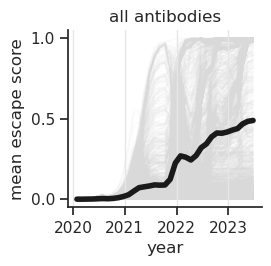

In [24]:
# Plot total escape over time
sources = [
    'WT convalescents', 'WT vaccinees',
    'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents',
]
print('Showing data from these sources:', sources)
metric = 'mean_escape' # 'wtd_escape_score' # 
data = (
    traj_df[traj_df['source'].isin(sources)]
    .groupby('year', as_index=False)[[metric]].mean()
)
#data[metric] = data[metric] / data[metric].max()
plt.figure(figsize=[2.5,2.3])
sns.lineplot(x='year', y=metric, data=data, linewidth=4, color='k')
data = traj_df[traj_df['source'].isin(sources)]
sns.lineplot(
    data=data, x="year", y="mean_escape", units='antibody',
    estimator=None, color=".85", linewidth=1, zorder=0, alpha=0.1
)
plt.grid(axis='x', color='0.9')
plt.title('all antibodies')
plt.yticks([0, 0.5, 1.0])
plt.ylabel('mean escape score')
sns.despine()
plt.show()

Show the escape trajectory for a single antibody of interest

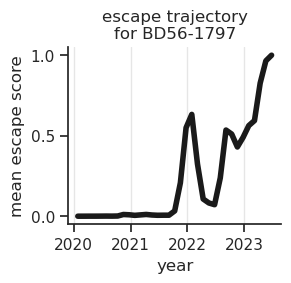

In [25]:
antibody_to_plot = 'BD56-1797' # 'LY-CoV555' #  
data = traj_df[traj_df['antibody'] == antibody_to_plot]
plt.figure(figsize=[2.75,2.3])
sns.lineplot(x='year', y='mean_escape', data=data, linewidth=4, color='k')
plt.grid(axis='x', color='0.9')
plt.title(f'escape trajectory\nfor {antibody_to_plot}')
plt.yticks([0, 0.5, 1.0])
plt.ylabel('mean escape score')
sns.despine()
plt.show()

Show the DMS data for the antibody from above

331 531


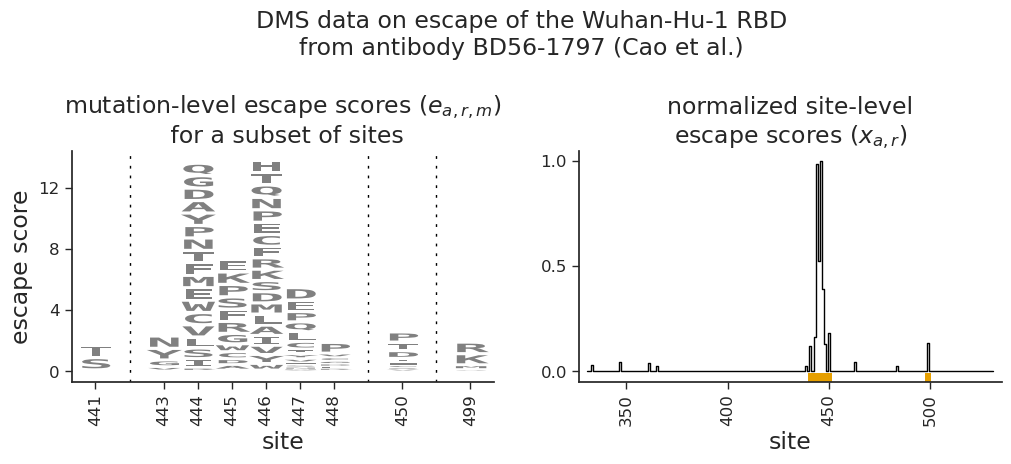

In [26]:
# Get DMS data
antibody_to_plot = 'BD56-1797'
data = dms_df[dms_df['antibody'] == antibody_to_plot].copy()

# Add entries of zero for sites with missing data (different antibodies
# have data for different subsets of sites; we assume that sites with
# missing data do not have strong escape mutations)
min_site = dms_df['site'].min()
max_site = dms_df['site'].max()
print(min_site, max_site)
missing_data = defaultdict(list)
sites_with_data = list(data['site'])
for site in range(min_site, max_site+1):
    if site not in sites_with_data:
        missing_data['site'].append(site)
        missing_data['mutation'].append('A')
        missing_data['mut_escape'].append(0)
missing_data = pd.DataFrame(missing_data)
data = pd.concat([data, missing_data])
data['color'] = '0.5'
data['antibody'] = antibody_to_plot

# Compute site-level scores
site_data = (
    data
    .groupby('site', as_index=False)[['mut_escape']]
    .sum()
    .rename(columns={'mut_escape' : 'site_mut_escape'})
)
data = data.merge(site_data, on='site', how='left')
data.sort_values('site', inplace=True)
data['normalized_mut_escape'] = data['mut_escape'] / data['site_mut_escape'].max()
data['normalized_site_mut_escape'] = data['site_mut_escape'] / data['site_mut_escape'].max()

# Select which sites to plot
sites_to_plot = list(site_data[site_data['site_mut_escape'] > 1]['site'])
data['show_site'] = data['site'].isin(sites_to_plot)

(fig, axs) = plt.subplots(ncols=2, figsize=[12,3])

_ = dmslogo.draw_logo(
    data[data['show_site'] == True],
    x_col="site",
    letter_col="mutation",
    letter_height_col="mut_escape",
    color_col='color',
    axisfontscale=1,
    ax=axs[0],
    ylabel='escape score',
    title='mutation-level escape scores ($e_{a,r,m}$)\n for a subset of sites'
    #xtick_col="site_label",
)

_ = dmslogo.draw_line(
    data,
    x_col="site",
    height_col="normalized_site_mut_escape",
    #xtick_col="site",
    show_col="show_site",
    axisfontscale=1,
    ax=axs[1],
    ylabel='',
    title='normalized site-level\nescape scores ($x_{a,r}$)'
)
axs[1].set(yticks=[0, 0.5, 1])
plt.suptitle(f'DMS data on escape of the Wuhan-Hu-1 RBD\nfrom antibody {antibody_to_plot} (Cao et al.)', y=1.35, fontsize=17)
plt.show()

How many times does a site have data for at least one mutation across all antibodies?

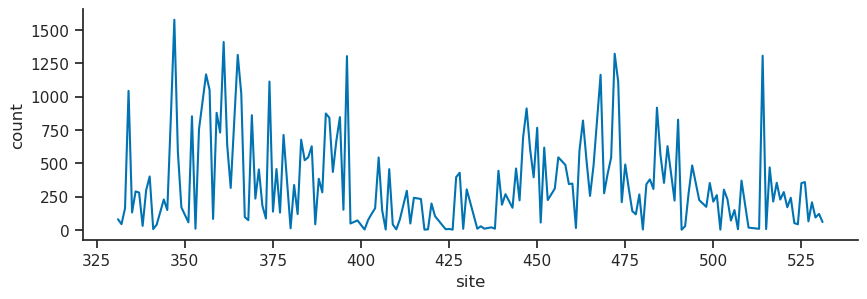

In [27]:
data = dms_df.drop_duplicates(subset=['site', 'antibody'])['site'].value_counts().reset_index()
data.columns = ['site', 'count']
plt.figure(figsize=[10,3])
sns.lineplot(x='site', y='count', data=data)
sns.despine()
plt.show()

In [28]:
data['site'].min(), data['site'].max()

(331, 531)

## Cluster antibodies by escape trajectory

We clustered antibody escape trajectories using the following approach:
* First, we identified trajectories that reached an escape score >0.2. We clustered those using the following steps, and then took all other trajectories and assigned them to a single manually assigned cluster (there are a lot of antibodies in this group, and including them in the clustering pipeline caused a few issues).
* Next, we took the antibodies with trajectories that reached an escape score >0.2 and used UMAP to reduce the dimensionality of the data. Specifically, each antibody has an escape score in each window. Each of these scores can be thought of as a dimension, such that the data is N dimensional where N is the number of windows. We use UMAP to reduce the number of dimensions to two.
* Next, we used k-means clustering to cluster the antibodies in the two-dimensional space. We set k = 20 to obtain fine-grained clusters. We then manually combined some of the clusters, obtaining 9 total clusters (with the 10th cluster being with set of antibodies from above with trajectories that do not reach >0.2).

In [29]:
# Identify all antibodies for which the mean viral escape score surpasses 0.2 in at
# least one sliding window
max_escape = traj_df.groupby('antibody')['mean_escape'].max()
abs_to_cluster = max_escape[max_escape > 0.2].index.values
print(f'Clustering {len(abs_to_cluster)} antibodies')

# Get matrix of escape scores clipped at an upper limit of 0.75
escape_matrix = (
    traj_df[traj_df['antibody'].isin(abs_to_cluster)]
    .pivot_table(index='antibody', columns='year', values='mean_escape')
    .clip(upper=0.75)
)

Clustering 916 antibodies


In [30]:
# Identify all antibodies for which the mean viral escape score surpasses 0.2 in at
# least one sliding window
max_escape = traj_df.groupby('antibody')['mean_escape'].max()
abs_to_cluster = max_escape[max_escape > 0.2].index.values
print(f'Clustering {len(abs_to_cluster)} antibodies')

# Fit the model to data
escape_matrix = (
    traj_df[traj_df['antibody'].isin(abs_to_cluster)]
    .pivot_table(index='antibody', columns='year', values='mean_escape')
    .clip(upper=0.75)
)
#umap_model = umap.UMAP(random_state=42)
#embedding = umap_model.fit_transform(escape_matrix)
#escape_matrix['umap_x'] = embedding[:, 0]
#escape_matrix['umap_y'] = embedding[:, 1]

# Use k-means to cluster
n_clusters = 20
#kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter = 8000).fit(escape_matrix[['umap_x', 'umap_y']])
kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter = 8000).fit(escape_matrix)
escape_matrix['kmeans_cluster'] = kmeans.labels_#.astype(str)

# Refine the clusters from k-means
manual_clusters = {

    15 : 1,

    0: 2,
    8: 2,
    12 : 2,

    6 : 3,

    2 : 4,
    14 : 4,

    17 : 5,
    18 : 5,

    7 : 6,
    10 : 6,
    11 : 6,

    4 : 7,
    5 : 7,
    13 : 7,
    16 : 7,
    19 : 7,

    1 : 8,
    9 : 8,

    3 : 9,
}
assert len(manual_clusters) == 20
escape_matrix['escape_cluster'] = escape_matrix['kmeans_cluster'].apply(lambda x: manual_clusters[x])

# Merge cluster data with the escape-trajectory data and IC50 data
if 'kmeans_cluster' not in traj_df.columns.values:
    
    traj_df = traj_df.merge(
        escape_matrix.reset_index()[[
            'antibody', #'umap_x', 'umap_y',
            'kmeans_cluster', 'escape_cluster'
        ]],
        on='antibody', how='left'
    )
    traj_df['escape_cluster'] = traj_df['escape_cluster'].fillna(10)
    traj_df['escape_cluster'] = traj_df['escape_cluster'].astype(int)
    
    ic50s_df = ic50s_df.merge(
        traj_df.drop_duplicates('antibody')[['antibody', 'escape_cluster']],
        on='antibody', how='left'
    )
    init_ic50s_df = init_ic50s_df.merge(
        traj_df.drop_duplicates('antibody')[['antibody', 'escape_cluster']],
        on='antibody', how='left'
    )

# output_file = '../results/escape_trajectories.csv'
# if not os.path.isfile(output_file):
#     print('Saving data to', output_file)
#     escape_matrix.to_csv(output_file, index=False)

Clustering 916 antibodies


Plot each cluster of antibody-escape trajectories.

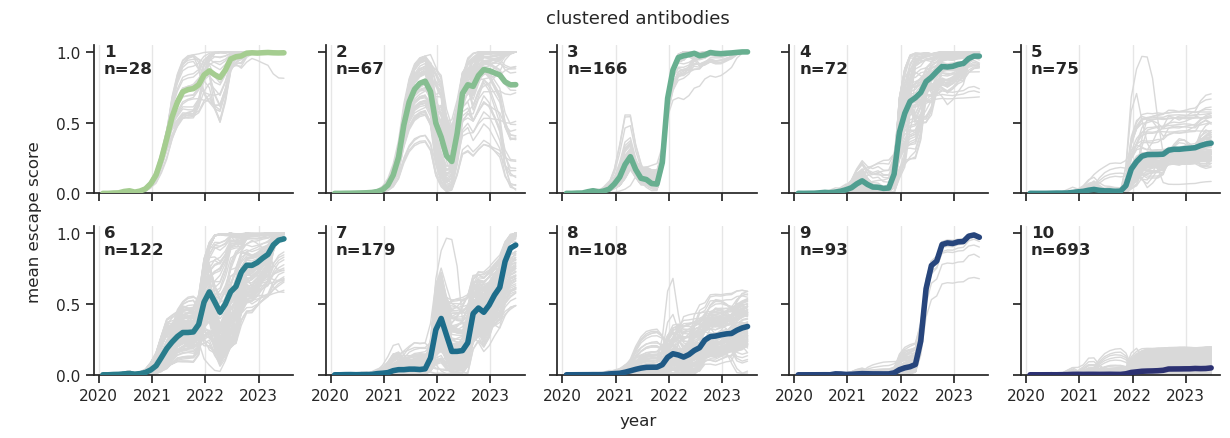

In [31]:
# Plot each antibody group's time series in its own facet
cluster_to_plot = 'escape_cluster' # 'kmeans_cluster' # 
data = traj_df.groupby([cluster_to_plot, 'year']).mean(numeric_only=True).reset_index()
data.sort_values(cluster_to_plot, inplace=True)
g = sns.relplot(
    data=data,
    x="year", y="mean_escape", col=cluster_to_plot, hue=cluster_to_plot,
    kind="line", palette="crest", # 'husl', 
    linewidth=4, zorder=5,
    col_wrap=5, height=2, aspect=1.2,
    legend=False,
)

# Then plot other antibodies from group or other antibody groups in the background
groupby_cols = [
    'antibody',
    cluster_to_plot,
    'year'
]
for group, ax in g.axes_dict.items():
    data = traj_df[
        ~(traj_df['antibody'].str.contains('Starr')) &
        ~(traj_df['antibody'].str.contains('Dong')) &
        (traj_df[cluster_to_plot] == group)
    ].groupby(groupby_cols).mean(numeric_only=True).reset_index()
    sns.lineplot(
        data=data, x="year", y="mean_escape", units=groupby_cols[0],
        estimator=None, color=".85", linewidth=1, ax=ax,
    )
    
    n_abs = data['antibody'].nunique()
    ax.set(xticks=[2020, 2021, 2022, 2023], yticks=[0,0.5,1], ylim=[0,1.05])
    ax.text(.05, .81, f'{group}\nn={n_abs}', transform=ax.transAxes, fontweight="bold")
    ax.grid(axis='x', color='0.9')

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "")
g.fig.text(0.5, -0.01, 'year', ha='center')
g.fig.text(-0.01, 0.5, '\nmean escape score', va='center', ha='center', rotation='vertical')
#g.tight_layout(h_pad=0.01)
g.tight_layout()
plt.suptitle('clustered antibodies', y=1.03, fontsize=13)
plt.show()

For a given set of clusters (either epitope or escape), plot the number of antibodies in per cluster and the distribution of their IC50s.

Showing data for 1603 antibodies from the following sources: ['WT convalescents', 'WT vaccinees', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']


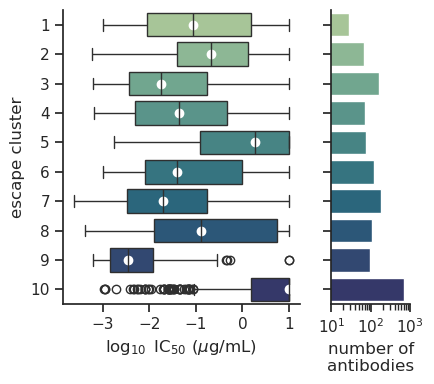

In [32]:
# Get input data
sources = [
    'WT convalescents', 'WT vaccinees',
    'BA.1 convalescents', 
    'BA.2 convalescents', 'BA.5 convalescents',
]
data = init_ic50s_df[init_ic50s_df['source'].isin(sources)].copy()
print(f'Showing data for {len(data)} antibodies from the following sources:', sources)

# Plot the data
cluster_col = 'escape_cluster' # 'epitope_cluster' # 
ic50_metric = 'log_IC50' # 'IC50_weight' # 
data.sort_values(cluster_col, inplace=True)
(fig, axs) = plt.subplots(
    ncols=2, figsize=[4.5,4], sharey=True,
    gridspec_kw={'width_ratios': [3, 1]}
)
sns.boxplot(
    x=ic50_metric, y=cluster_col, data=data,
    orient='h', color='0.5', hue=cluster_col, palette='crest',
    legend=False, ax=axs[0]
)
sns.pointplot(
    x=ic50_metric, y=cluster_col, data=data,
    orient='h', ax=axs[0],
    estimator=np.median, errorbar=None, linestyle='none',
    markers="o", color='w', markersize=5, 
)
ylabel = cluster_col.replace('_', ' ')
if cluster_col == 'epitope_cluster':
    ylabel = 'epitope (Cao et al.)'
axs[0].set(
    ylabel=ylabel, xlabel=r'$\log_{10}$ IC$_{50}$ ($\mu$g/mL)',
    xticks=[-3, -2, -1, 0, 1]
)
sns.countplot(
    y=cluster_col, data=data,
    color='0.5', hue=cluster_col, palette='crest',
    legend=False, ax=axs[1]
)
axs[1].set(
    xlabel='number of\nantibodies', ylabel='',
    xscale='log', xlim=[10,1000]
)

plt.tight_layout()
sns.despine()
plt.show()

Make a heatmap showing how many antibodies from a given epitope cluster fall in a given escape cluster.

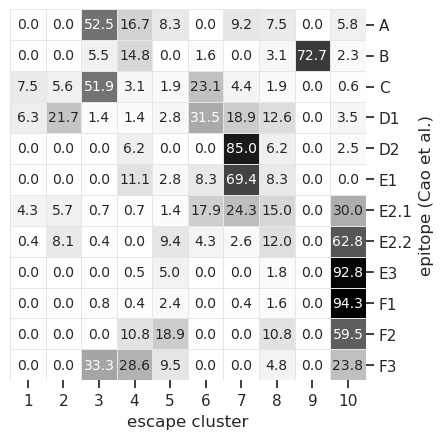

In [33]:
# Get a matrix with the number of antibodies in epitope clusters from Cao et al. vs.
# escape clusters computed here
data = (
    traj_df[
        ~(traj_df['antibody'].str.contains('Starr')) &
        ~(traj_df['antibody'].str.contains('Dong'))
    ]
    .drop_duplicates(subset='antibody')
    .groupby(['epitope_cluster', 'escape_cluster'], as_index=False)['antibody'].count()
    .pivot_table(
        index='escape_cluster', columns='epitope_cluster',
        values='antibody'
    )
    .fillna(0)
    .apply(lambda col: 100 * col/col.sum())
).T

# Plot the data
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", ["white", "black"])
cg = sns.clustermap(
    data, annot=True, fmt=".1f",
    row_cluster=False, col_cluster=False, cmap=cmap,
    figsize=(5.5,5.5), annot_kws={"size": 10}, linewidths=0.5, linecolor='0.9'
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set(
    xlabel='escape cluster', ylabel='epitope (Cao et al.)'
)
#ax.set_title('percent composition by row', y=1.02)
plt.show()

Make a heatmap showing the fraction of neutralizing antibodies from a given source fall in a given escape cluster

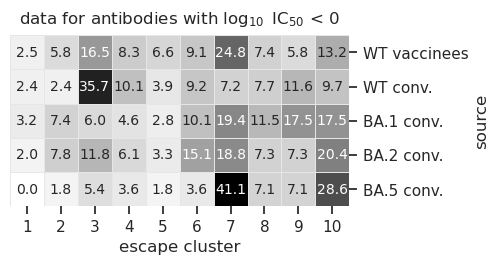

In [34]:
sources = [
    'WT vaccinees', 'WT convalescents',
    'BA.1 convalescents', 
    'BA.2 convalescents', 'BA.5 convalescents',
]

neut_abs = init_ic50s_df[init_ic50s_df['log_IC50'] < 0]['antibody']
data = (
    ic50s_df[ic50s_df['antibody'].isin(neut_abs)]
    .drop_duplicates(subset='antibody')
    .groupby(['source', 'escape_cluster'], as_index=False)['antibody'].count()
    .pivot_table(
        index='escape_cluster', columns='source',
        values='antibody'
    )
    .fillna(0)
    .apply(lambda col: 100 * col/col.sum())
    .rename(columns={col : col.replace('convalescents', 'conv.') for col in sources})
).T

# Plot the data
sources = [col.replace('convalescents', 'conv.') for col in sources]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", ["white", "black"])
cg = sns.clustermap(
    data.loc[sources], annot=True, fmt=".1f",
    row_cluster=False, col_cluster=False, cmap=cmap,
    figsize=(6,3), annot_kws={"size": 10}, linewidths=0.5, linecolor='0.9'
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set(xlabel='escape cluster', ylabel='source')
ax.set_title('data for antibodies with $\log_{10}$ IC$_{50}$ < 0', y=1.02)
plt.show()

## Validate predictions using IC50 data

What is the correlation in IC50s between different experiments?

0.87 0.0


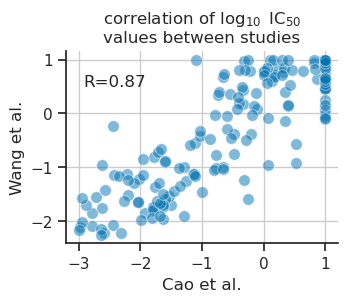

In [35]:
viruses = ['D614G', 'BA.1']
data = (
    ic50s_df[ic50s_df['virus'].isin(viruses)]
    .pivot_table(index=['antibody', 'virus'], columns='study', values='log_IC50')
    .dropna(subset=['Cao et al.', 'Wang et al. pv'])
)

(r, p) = scipy.stats.pearsonr(data['Cao et al.'], data['Wang et al. pv'])
print(round(r, 2), round(p, 2))

# Plot data
plt.figure(figsize=[3.5,2.5])
sns.scatterplot(x='Cao et al.', y='Wang et al. pv', data=data, s=70, alpha=0.5)
plt.annotate(f'R={round(r,2)}', [-2.92, 0.5])
plt.ylabel('Wang et al.')
plt.title('correlation of $\log_{10}$ IC$_{50}$\nvalues between studies')
plt.grid()
sns.despine()
plt.show()

Identify viral sequences that match specific variants of concern with experimental IC50 data, then merge their predicted escape scores for each antibody with the dataframe with IC50 data for those same variants and antibodies.

In [36]:
# Make a list of mutations in each strain in the alignmnet relative to WH1
strain_muts_df = escape_scores_df.drop_duplicates('strain').copy()
strain_muts_df['all_aa_substitutions'] = strain_muts_df['all_aa_substitutions'].fillna('')
strain_muts_df['mutations'] = strain_muts_df['all_aa_substitutions'].apply(
    lambda x: set(x.split(' '))
)

# Get a dictionary giving the mutations in each clade
voc_muts_dict = clusters.clusters

# Map strains from IC50 experiments to clades from above dict
voc_to_clade_dict = {
    'Alpha' : 'Alpha',
    'Beta' : 'Beta',
    'Gamma' : 'Gamma',
    'Delta' : 'Delta',
    'Lambda' : '21GLambda',
    'BA.1' : '21K.Omicron',
    'BA.2' : '21L.Omicron',
    'BA.2.75' : '22D',
    'BA.5' : '22B',
    'BQ.1.1' : '22E',
    'XBB' : '22F'
}
voc_to_strain_dict = {
    'D614G' : ('Wuhan-Hu-1/2019', [])
}
muts_to_ignore = ['R493Q', 'Q493Q']
for (voc, clade) in voc_to_clade_dict.items():
    muts = [
        f"{entry['left']}{entry['pos']}{entry['right']}" for entry in
        voc_muts_dict[clade]['mutations']['nonsynonymous']
        if entry['gene'] == 'S'
    ]
    for mut in muts_to_ignore:
        if mut in muts:
            muts.remove(mut)
    if voc == 'BQ.1.1':
        muts.append('R346T')
    print(voc, muts)

    # Get the virus with the fewest differences
    strain_muts_df['diffs'] = strain_muts_df['mutations'].apply(
        lambda x: set.symmetric_difference(x, muts)
    )
    strain_muts_df['ndiffs'] = strain_muts_df['diffs'].apply(lambda x: len(x))
    strain_muts_df.sort_values(['ndiffs', 'strain'], inplace=True)
    virus = strain_muts_df['strain'].iloc[0]
    ndiffs = strain_muts_df['ndiffs'].iloc[0]
    diffs = strain_muts_df['diffs'].iloc[0]
    voc_to_strain_dict[voc] = (virus, muts)
    
    if ndiffs > 0:
        print(virus, ndiffs, diffs, '\n')

# Get predicted escape scores for each VOC relative to each antibody
dfs = []
for (voc, voc_values) in voc_to_strain_dict.items():
    data = escape_scores_df[escape_scores_df['strain'] == voc_values[0]].copy()
    data['virus'] = voc
    dfs.append(data)
pred_ic50s = pd.concat(dfs)

# Then merge the above predictions with the experimental IC50 data on the same VOC/antibody
# combinations
if 'escape_score' not in ic50s_df:
    ic50s_df = ic50s_df.merge(
        pred_ic50s[['virus', 'antibody', 'escape_score']],
        on=['antibody', 'virus'], how='left'
    )

Alpha ['H69-', 'V70-', 'Y144-', 'N501Y', 'A570D', 'D614G', 'P681H', 'T716I', 'S982A', 'D1118H']
Beta ['D80A', 'D215G', 'L241-', 'L242-', 'A243-', 'K417N', 'E484K', 'N501Y', 'D614G', 'A701V']
Gamma ['L18F', 'T20N', 'P26S', 'D138Y', 'R190S', 'K417T', 'E484K', 'N501Y', 'D614G', 'H655Y', 'T1027I', 'V1176F']
Delta ['T19R', 'G142D', 'E156-', 'F157-', 'R158G', 'L452R', 'T478K', 'D614G', 'P681R', 'D950N']
Lambda ['G75V', 'T76I', 'R246-', 'S247-', 'Y248-', 'L249-', 'T250-', 'P251-', 'G252-', 'D253N', 'L452Q', 'F490S', 'D614G', 'T859N']
BA.1 ['A67V', 'H69-', 'V70-', 'T95I', 'G142-', 'V143-', 'Y144-', 'Y145D', 'N211-', 'L212I', 'G339D', 'S371L', 'S373P', 'S375F', 'K417N', 'N440K', 'G446S', 'S477N', 'T478K', 'E484A', 'Q493R', 'G496S', 'Q498R', 'N501Y', 'Y505H', 'T547K', 'D614G', 'H655Y', 'N679K', 'P681H', 'N764K', 'D796Y', 'N856K', 'Q954H', 'N969K', 'L981F']
BA.2 ['T19I', 'L24-', 'P25-', 'P26-', 'A27S', 'G142D', 'V213G', 'G339D', 'S371F', 'S373P', 'S375F', 'T376A', 'D405N', 'R408S', 'K417N', 'N440

Do experimentally IC50 values support the predicted escape scores?

In [37]:
# Plotting params
virus_order = [
    'D614G',
    'Alpha', 'Beta', 'Gamma',
    'Lambda', 'Delta', 
    'Omicron',
    'BA.1', 'BA.2', 'BA.2.75',
    'BA.5', 'BQ.1.1',
    'XBB', 'XBB.1.5'
]
studies = [
    'Wang et al. pv',
    #'Wang et al. av',
    'Cao et al.',
]

for (study, data) in ic50s_df.groupby('study'):

    # Select antibodies with a logIC50 below zero for D614G
    pivoted_data = data.pivot(
        index='antibody', columns='virus', values='log_IC50'
    )
    antibodies_to_plot = list(set(pivoted_data[
        (pivoted_data['D614G'] <= 0)
    ].index.values))
    print(study, len(pivoted_data), len(antibodies_to_plot))

Cao et al. 1603 846
Wang et al. av 90 68
Wang et al. pv 90 66


1


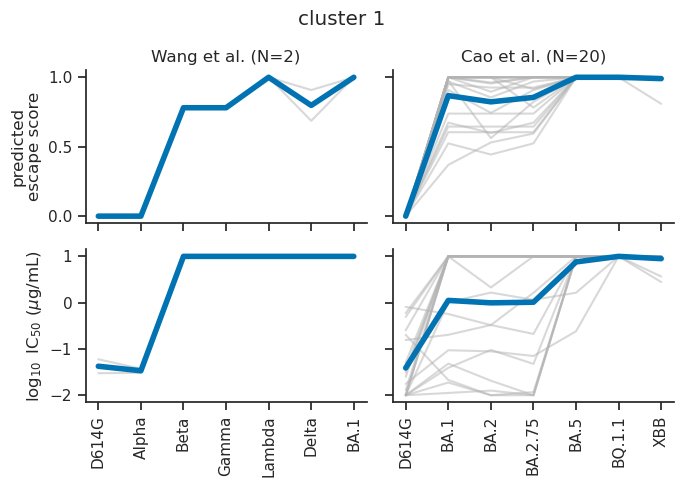

2


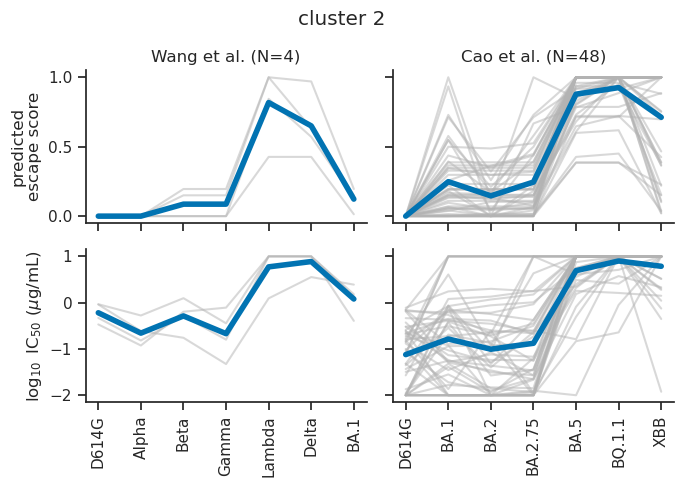

3


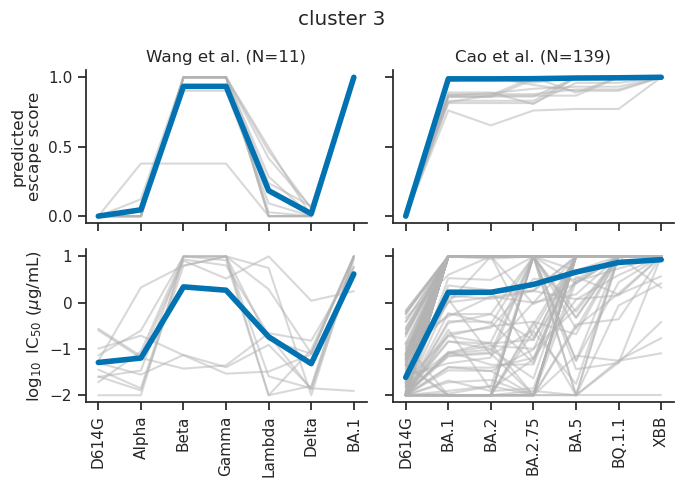

4


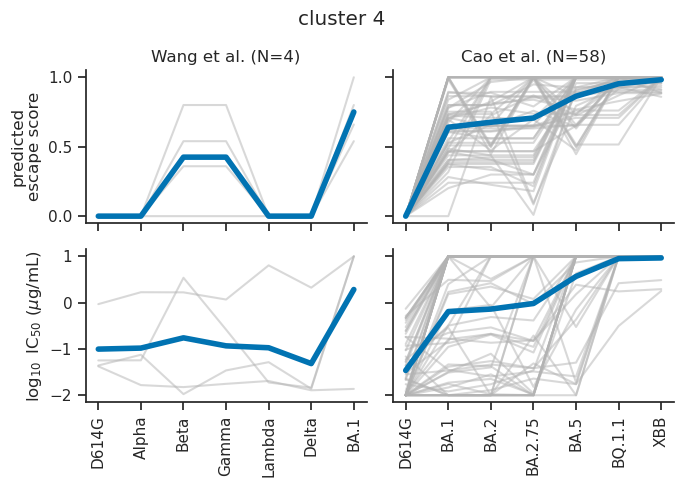

5


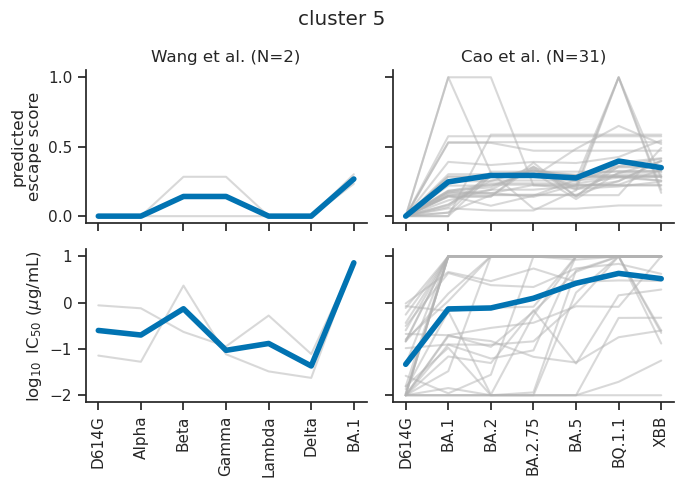

6


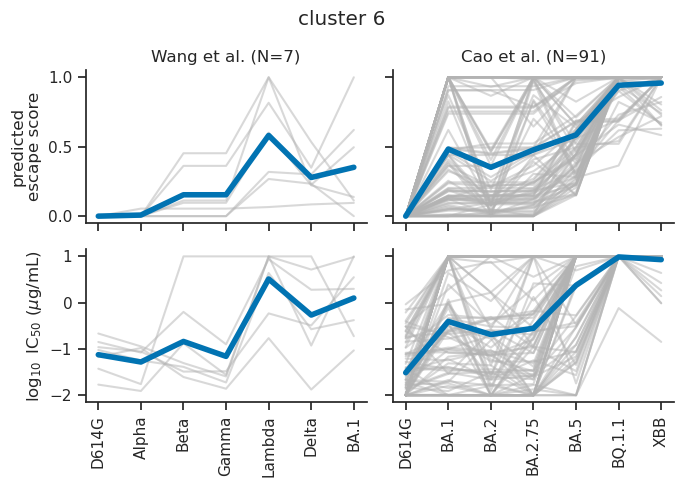

7
26 17
156 59


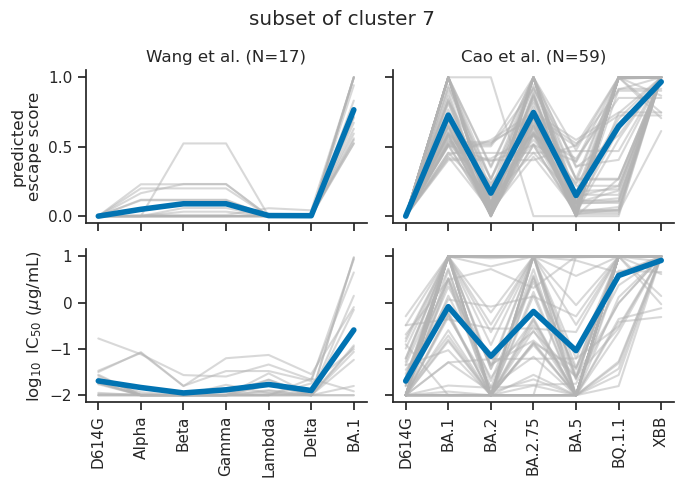

8


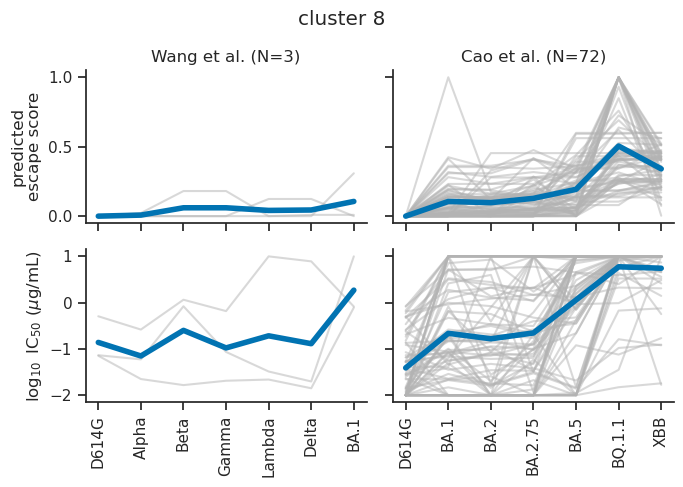

9


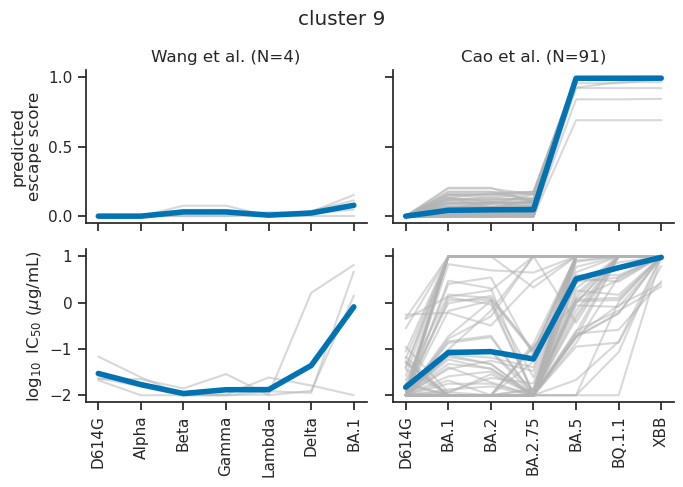

10


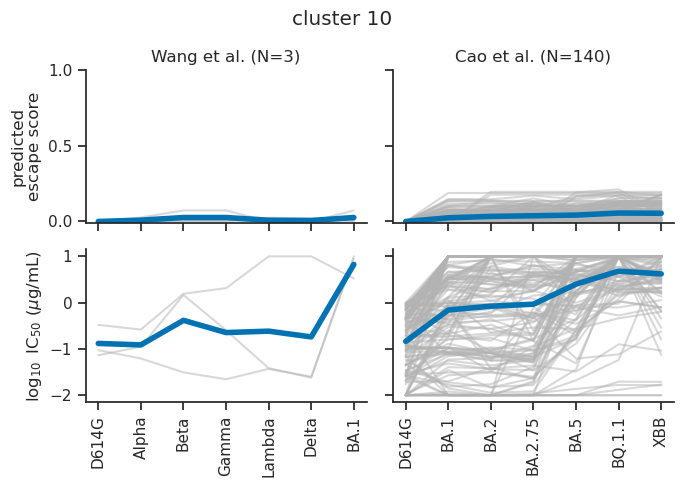

In [38]:
# Plotting params
virus_order = [
    'D614G',
    'Alpha', 'Beta', 'Gamma',
    'Lambda', 'Delta', 
    'Omicron',
    'BA.1', 'BA.2', 'BA.2.75',
    'BA.5', 'BQ.1.1',
    'XBB', 'XBB.1.5'
]
studies = [
    'Wang et al. pv',
    #'Wang et al. av',
    'Cao et al.',
]
study_pal = {
    'Wang et al. pv' : '#0173b2',
    'Cao et al.' : 'firebrick'
}

clusters_to_plot = list(range(1, 11))
#clusters_to_plot = [2, 7]
ic50_corr_dict = defaultdict(list)
ab_corr_dict = defaultdict(list)

for cluster in clusters_to_plot:

    print(cluster)
    (fig, axs) = plt.subplots(
        ncols=2, nrows=2, figsize=[7,5], sharex='col', sharey='row',
        gridspec_kw={'width_ratios': [1, 1]}
    )
    axs = axs.reshape(-1)

    for (ax_i, study) in enumerate(studies):
        
        # Get IC50 data
        data = ic50s_df[
            (ic50s_df['escape_cluster'] == cluster) &
            (ic50s_df['virus'].isin(virus_order)) &
            (ic50s_df['study'] == study)
        ].copy()
        data['clipped_log_IC50'] = data['log_IC50'].clip(lower=-2)

        # Sort the viruses for the x-axis
        virus_index_dict = {
            virus : i
            for (i, virus) in enumerate(virus_order)
        }
        data['order'] = data['virus'].apply(lambda x: virus_index_dict[x])
        data.sort_values('order', inplace=True)
        hue_order = sorted(data['antibody'].unique())
        
        # Select antibodies with a logIC50 below zero for D614G
        pivoted_data = data.pivot(
            index='antibody', columns='virus', values='log_IC50'
        )
        antibodies_to_plot = set(pivoted_data[
            (pivoted_data['D614G'] <= 0)
        ].index.values)
        data = data[data['antibody'].isin(antibodies_to_plot)]

        # Compute the correlation between escape scores and IC50s
        IC50_metric = 'log_IC50'
        ab_rs = []
        for (antibody, ab_data) in data.groupby('antibody'):
            r = ab_data['escape_score'].corr(ab_data[IC50_metric])
            if np.isnan(r):
                ab_rs.append(0)
            else:
                ab_rs.append(r)
            ab_corr_dict['cluster'].append(cluster)
            ab_corr_dict['study'].append(study)
            ab_corr_dict['antibody'].append(antibody)
            ab_corr_dict['r'].append(round(r, 2))

        ################
        # Make line plots
        ################

        # For cluster 7, select a subset of antibodies to plot in the line plot
        pivoted_data = data.pivot(
            index='antibody', columns='virus', values='escape_score' # 'log_IC50'
        )
        if (cluster in [7]): # ('Cao' in study) and
            antibody_subset = set(pivoted_data[
                (pivoted_data['BA.1'] > 0.4) & 
                (pivoted_data['D614G'] <= 0)
            ].index.values)
            data = data[data['antibody'].isin(antibody_subset)]
            print(len(antibodies_to_plot), len(antibody_subset))

        # Plot data
        for metric in ['escape_score', 'clipped_log_IC50']:
            if metric == 'escape_score':
                n_abs = len(data['antibody'].unique())
                median_r = np.median(np.array(ab_rs))
                axs[ax_i].set(
                    title=f"{study.replace(' pv', '')} (N={n_abs})",
                    yticks=[0, 0.5, 1], ylabel='predicted\nescape score'
                )
                metric_ax_i = ax_i
            else:
                axs[ax_i+2].set(
                    ylabel=r'$\log_{10}$ IC$_{50}$ ($\mu$g/mL)'
                )
                metric_ax_i = ax_i + 2
            if len(data) == 0:
                continue
            sns.lineplot(
                x='virus', y=metric, data=data, ax=axs[metric_ax_i],
                units='antibody', estimator=None, c='0.7', alpha=0.5
                #hue='antibody', hue_order=hue_order,
            )
            sns.lineplot(
                x='virus', y=metric, data=data, ax=axs[metric_ax_i],
                linewidth=4, estimator='mean', errorbar=None, # color=study_pal[study],
            )

        for tick in axs[ax_i+2].get_xticklabels():
            tick.set_rotation(90)

    axs[0].set(yticks=[0, 0.5, 1])
    axs[1].set(ylabel='')
    axs[2].set(xlabel='')
    axs[3].set(xlabel='', ylabel='')
    if cluster in [7]:
        title = f'subset of cluster {cluster}' # f'cluster {cluster}' # 
    else:
        title = f'cluster {cluster}'
    plt.suptitle(title, y=0.97)
    plt.tight_layout()
    sns.despine()
    plt.show()

ab_corr_df = pd.DataFrame(ab_corr_dict)

Plot correlation coefficients by cluster and study

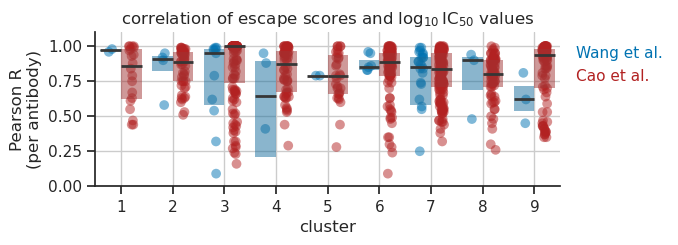

In [39]:
study_pal = {
    'Wang et al.' : '#0173b2',
    'Cao et al.' : 'firebrick'
}
data = ab_corr_df[ab_corr_df['cluster'] != 10].copy()
data['study'] = data['study'].replace('Wang et al. pv', 'Wang et al.')
plt.figure(figsize=[6,2])
hue_order = ['Wang et al.', 'Cao et al.']
sns.stripplot(
    x='cluster', y='r', data=data,
    hue='study', hue_order=hue_order, palette=study_pal,
    dodge=True, alpha=0.5, s=7
)
sns.boxplot(
    x='cluster', y='r', data=data,
    hue='study', hue_order=hue_order, palette=study_pal,
    legend=False, showfliers=False, whis=0, linewidth=0,
    medianprops={"linewidth": 2}, boxprops={'alpha':.5}, zorder=10,
)
ax = plt.gca()
ax.set(
    ylim=[0,1.1], ylabel='Pearson R\n(per antibody)', yticks=[0, 0.25, 0.5, 0.75, 1],
    title=r'correlation of escape scores and $\log_{10}\text{IC}_{50}$ values'
)
#plt.legend(bbox_to_anchor=[1,1])
ax.legend(
    frameon=False, markerscale=0, labelcolor='linecolor',
    loc='upper right', bbox_to_anchor=(1.25,1)
)
plt.grid()
sns.despine()
plt.show()

Notes on antibodies from Bloom lab

* LY-CoV555
    * an example of an antibody where escape is maintained by different mutations? First 484, then 452?
    * IC50 data from 
* LY-CoV016 and REGN10933 examples of an antibody where escape dips with delta (supported by this paper: https://www.nature.com/articles/s41586-021-03777-9; https://www.sciencedirect.com/science/article/pii/S2211124722013845?via%3Dihub)
    * though DMS predictions for REGN10933 are inaccurate for pre-Delta VOCs, so don't see dip
* REGN10987 an example of an antibody where escape at year 2.5?
* other antibodies include examples of escape tracking with a single mutation that increases monotonically until it fixes.


Atlas of IC50s against many different Omicron variants: https://www.sciencedirect.com/science/article/pii/S2666379123000976?via%3Dihub

In [40]:
abs_to_examine = ic50s_df[
    (ic50s_df['escape_cluster'] == 7) &
    (ic50s_df['escape_score'] > 0.4) &
    (ic50s_df['virus'] == 'BA.1')
]['antibody'].unique()

ic50s_df[
    (ic50s_df['study'] == 'Cao et al.') &
    (ic50s_df['virus'] == 'BA.2') &
    (ic50s_df['log_IC50'] < 0) &
    (ic50s_df['antibody'].isin(abs_to_examine))
].drop_duplicates('antibody')['source'].value_counts()

BA.2 convalescents    15
WT vaccinees          13
BA.5 convalescents    11
BA.1 convalescents    10
WT convalescents       1
Name: source, dtype: int64

## Examine the evolutionary dynamics giving rise to escape trajectories

For each antibody, identify escape mutations that are correlated with its escape trajectory.

In [41]:
# Iterate over each antibody and compute correlations
all_mut_sites = mut_freq_df['site'].unique()
dfs = []
for (ab_info, data) in traj_df.groupby(['escape_cluster', 'antibody']):
    
    (cluster, antibody) = ab_info

    # Merge escape trajectory data for antibody with mut freqs and DMS data
    ab_site_escape_df = site_escape_df[
        (site_escape_df['antibody'] == (antibody))
    ].copy()
    ab_site_escape_df.rename(columns = {'escape':'site_escape'}, inplace=True)
    data = (
        data
        .merge(mut_freq_df, on=['time', 'year'], how='left')
        .merge(ab_site_escape_df, on=['antibody', 'site'], how='left')
    )
    data['site_escape'] = data['site_escape'].fillna(0)

    # Make a list of sites with escape scores above a threshold
    sites = data[
        (data['mut_freq'].notnull()) &
        (data['site_escape'] > 0.2)
    ]['site'].unique()
    if len(sites) == 0:
        continue

    # Compute stats quantifying trends between mut freqs and escape score,
    # ignoring mutations that don't reach a frequency threshold
    corr_dict = defaultdict(list)
    for site in sites:
        data_i = data[data['site'] == site]
        max_freq = round(data_i['mut_freq'].max(), 2)
        if max_freq < 0.2:
            continue
        r = round(data_i['mean_escape'].corr(data_i['mut_freq']), 2)
        corr_dict['cluster'].append(cluster)
        corr_dict['antibody'].append(antibody)
        corr_dict['site'].append(site)
        corr_dict['max_freq'].append(max_freq)
        corr_dict['r'].append(r)
    corr_df = pd.DataFrame(corr_dict)
    if len(corr_df) == 0:
        continue

    # Merge with site-escape data
    corr_df = corr_df.merge(ab_site_escape_df, on=['antibody', 'site'], how='left')
    corr_df['site_escape'] = corr_df['site_escape'].fillna(0)
    dfs.append(corr_df)

escape_mut_corr_df = pd.concat(dfs)
escape_mut_corr_df.head()

,cluster,antibody,site,max_freq,r,site_escape,study,normalized_escape
0,1,BD-670,446,1.00,0.67,2.682674,imprinted_2022,0.324411
1,1,BD-670,452,0.96,0.49,4.263748,imprinted_2022,0.515608
2,1,BD-670,484,1.00,0.93,8.269362,imprinted_2022,1.000000
3,1,BD-670,486,0.99,0.70,7.975429,imprinted_2022,0.964455
4,1,BD-670,490,1.00,0.48,7.840567,imprinted_2022,0.948147


For each cluster, count the number of times a given site is:
* correlated with an antibody's escape trajectory
* reaches an appreciable frequency in nature
* has an appreciably large site-escape score from DMS

In [42]:
for (cluster, data) in escape_mut_corr_df.groupby('cluster'):
    data = data[
        (data['r'] > 0.2) &
        (data['max_freq'] > 0.3) &
        (data['site_escape'] > 0.3)
    ]
    print('\n')
    print('cluster:', cluster)
    print('n antibodies:', len(data['antibody'].unique()))
    print(data['site'].value_counts())



cluster: 1
n antibodies: 28
484    28
452    28
490    26
446    18
346    14
493     6
496     6
486     5
498     4
405     2
460     2
339     2
477     2
440     2
371     2
408     1
501     1
Name: site, dtype: int64


cluster: 2
n antibodies: 67
452    67
490    55
484    39
346    28
446    24
460     2
339     2
486     2
405     2
498     2
445     2
376     1
501     1
371     1
496     1
Name: site, dtype: int64


cluster: 3
n antibodies: 166
484    134
490     89
417     69
493     61
486     39
460     35
501     32
496     30
405     27
346     25
408     20
452     16
505     12
446     12
498     10
445      6
440      3
477      2
375      2
376      2
371      2
478      1
Name: site, dtype: int64


cluster: 4
n antibodies: 72
484    44
486    31
417    21
408    12
346    11
376    10
446     9
460     9
371     9
445     8
405     7
339     7
490     7
477     6
440     5
501     5
493     5
452     5
478     4
498     3
496     3
375     2
373     2
Name: site, 

Examine DMS data for antibodies within each cluster

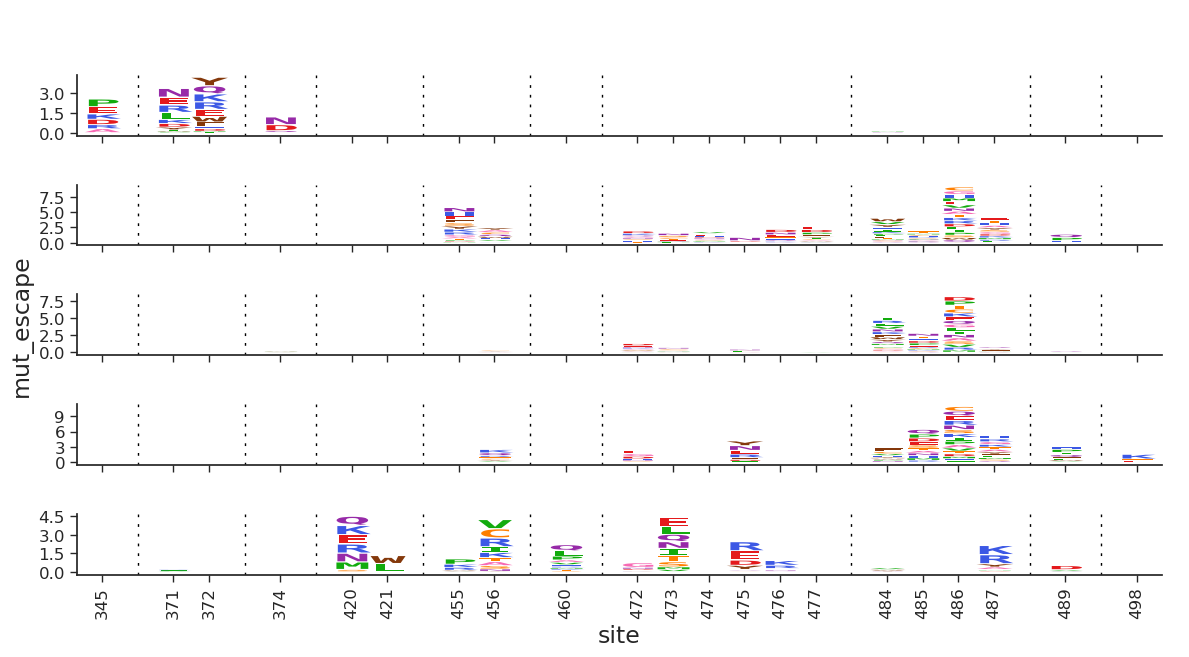

In [43]:
# Make a list of antibodies to plot
escape_cluster = 4
nabs = 5

site_dms_df = dms_df.groupby(['antibody', 'site'], as_index=False)['mut_escape'].sum()
site_max_df = site_dms_df.groupby('antibody', as_index=False)['mut_escape'].max()
abs_with_high_site_escape_scores = site_max_df[site_max_df['mut_escape'] > 2]['antibody'].unique()

# Omar: you can plot any antibodies you want simply by changing the "antibodies_to_plot" list
# to be whatever you want
random.seed(1)
data = traj_df.drop_duplicates('antibody')
antibodies_to_plot = random.sample(list(
    data[
        (data['antibody'].isin(abs_with_high_site_escape_scores)) &
        (data['escape_cluster'] == escape_cluster)
    ]['antibody']
), nabs)

# Get DMS data, adding entries of zero for missing mutations
data_to_plot = dms_df[dms_df['antibody'].isin(antibodies_to_plot)].copy()
null_dict = defaultdict(list)
for site in data_to_plot['site'].unique():
    for mutation in data_to_plot['mutation'].unique():
        null_dict['site'].append(site)
        null_dict['mutation'].append(mutation)
        null_dict['mut_escape'].append(0.0)
null_df = pd.DataFrame(null_dict)
dfs = []
for (ab, ab_data) in data_to_plot.groupby('antibody'):
    null_data = null_df.copy()
    null_data['antibody'] = ab
    ab_data = (
        pd.concat([null_data, ab_data])
        .groupby(['antibody', 'site', 'mutation'], as_index=False)['mut_escape'].sum()
    )
    dfs.append(ab_data)
data_to_plot = pd.concat(dfs)

# Identify which sites to plot
site_data = data_to_plot.groupby(['antibody', 'site'], as_index=False)['mut_escape'].sum()
sites_to_plot = list(site_data[site_data['mut_escape'] > 1]['site'])
data_to_plot = data_to_plot[data_to_plot['site'].isin(sites_to_plot)]

# Make plot
(fig, axes) = dmslogo.facet_plot(
    data_to_plot,
    gridrow_col="antibody",
    x_col="site",
    show_col=None,
    share_ylim_across_rows=False,
    #draw_line_kwargs=dict(height_col="totfracsurvive", xtick_col="site"),
    draw_logo_kwargs=dict(
        letter_col="mutation", letter_height_col="mut_escape",
        xlabel="site",
    ),
    height_per_ax=1, # Omar: you can change this number to make the plots bigger vertically
    #line_titlesuffix="site-level selection",
    #logo_titlesuffix="mutation-level selection",
)
for ax in axes:
    ax[0].set(title='') # Omar: you can remove this loop to include ab titles
plt.show()

Make a list of sites that appear to drive escape in each cluster based on the above analyses. Then, for each cluster, plot the change in frequency of mutations at those sites over time.

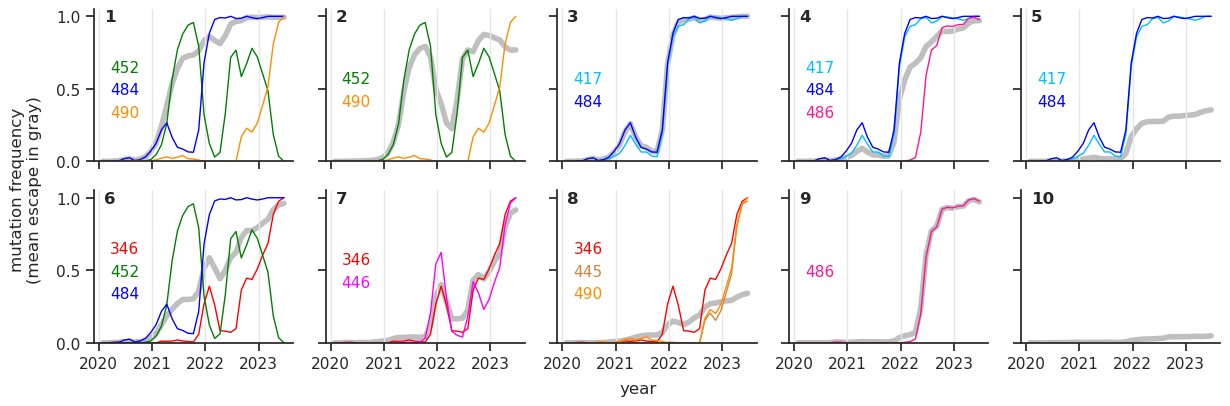

In [44]:
# Make a list of key sites driving escape for each cluster
# Omar: here's the manual list of key mutations per cluster
key_sites_per_cluster = {
    1 : [452, 484, 490], # 
    2 : [452, 490],
    3 : [484, 417],
    4 : [417, 484, 486],
    5 : [417, 484],
    6 : [452, 346, 484],
    7 : [346, 446],
    8 : [346, 445, 490],
    9 : [486],
    10 : []
}
mut_palette = {
    452 : 'green',
    484 : 'blue',
    490 : 'darkorange',
    417 : 'deepskyblue',
    376 : 'firebrick',
    405 : 'brown',
    408 : 'maroon',    
    346 : 'red',
    446 : 'magenta',
    445 : 'peru',
    486 : 'deeppink',
}

# Plot each antibody group's time series in its own facet
cluster_to_plot = 'escape_cluster' # 'kmeans_cluster' # 
data = (
    traj_df[
        ~(traj_df['antibody'].str.contains('Starr')) &
        ~(traj_df['antibody'].str.contains('Dong'))
    ]
    .groupby([cluster_to_plot, 'year']).mean(numeric_only=True).reset_index()
)
data.sort_values(cluster_to_plot, inplace=True)
g = sns.relplot(
    data=data,
    x="year", y="mean_escape", col=cluster_to_plot,
    kind="line", color='0.75', #palette="crest", # 'husl', 
    linewidth=4, zorder=0,
    col_wrap=5, height=2, aspect=1.2,
    legend=False,
)

# Then plot mutation frequencies
groupby_cols = [
    cluster_to_plot,
    'time'
]
for (group, ax) in g.axes_dict.items():
    data = mut_freq_df[mut_freq_df['site'].isin(key_sites_per_cluster[group])]
    if len(data) > 0:
        g_i = sns.lineplot(
            data=data, x="year", y="mut_freq", units='site',
            estimator=None, linewidth=1, ax=ax, palette=mut_palette,
            hue='site'
        )    
    ax.set(xticks=[2020, 2021, 2022, 2023], yticks=[0,0.5,1], ylim=[0,1.05])
    ax.text(.05, .92, group, transform=ax.transAxes, fontweight="bold")
    if group == 10:
        continue
    g_i.legend_.set_title(None)
    ax.legend(
        frameon=False, handlelength=0, labelcolor='linecolor',
        loc='center left', bbox_to_anchor=(-0.05,0.47)
    )
    ax.grid(axis='x', color='0.9')

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "")
g.fig.text(0.5, -0.01, 'year', ha='center')
g.fig.text(-0.01, 0.5, 'mutation frequency\n(mean escape in gray)', va='center', ha='center', rotation='vertical')
#plt.suptitle('clustered antibodies', y=1.03, fontsize=13)
g.tight_layout()
plt.show()

For individual antibodies of interest, make plots comparing three things:
* the antibody's escape trajectory
* the frequency of mutations at sites of strong escape
* the frequency of clades, which shows clade-displacement events

In [45]:
clade_freqs_df['clade'].unique()

array(['19A', '19B', '20A', '20B', '20C', '20D', '20E', '20F', '20G',
       '20H (Beta)', '20I (Alpha)', '20J (Gamma)', '21A (Delta)',
       '21B (Kappa)', '21C (Epsilon)', '21D (Eta)', '21E (Theta)',
       '21F (Iota)', '21G (Lambda)', '21H (Mu)', '21I (Delta)',
       '21J (Delta)', '21K (BA.1)', '21L (BA.2)', '22A (BA.4)',
       '22B (BA.5)', '22C (BA.2.12.1)', '22D (BA.2.75)', '22E (BQ.1)',
       '22F (XBB)', '23A (XBB.1.5)', '23B (XBB.1.16)', '23C (Omicron)',
       '23D (XBB.1.9)', '23E (XBB.2.3)', '23F (Omicron)', 'recombinant'],
      dtype=object)

In [46]:
clade_plotting_params = {
    2 : [
        ('Delta,\nKappa,\nLambda', [
            '21A (Delta)',
            '21B (Kappa)',
            '21G (Lambda)',
            #'21A/I/J (Delta)',
            '21I (Delta)',
            '21J (Delta)',
        ], 2021.65, 0.3, 'k'),
        ('all other\nOmicron\nclades', [
            '22A (BA.4)',
            '22B (BA.5)',
            '22C (BA.2.12.1)',
            '22E (BQ.1)',
            '22F (XBB)',
            '23A (XBB.1.5)',
            '23B (XBB.1.16)',
            '23D (XBB.1.9)',
            '23E (XBB.2.3)'
        ], 2022.95, 0.325, 'k'),
        ('BA.1/2/\n2.75', [
            '21K (BA.1)',
            '21L (BA.2)',
            '22D (BA.2.75)',
        ], 2022.22, 0.72, 'k'
        ),
    ],
    3 : [
        ('20B,\nBeta, Gamma', [
            '20B',
            '20H (Beta)',
            '20J (Gamma)',
        ], 2020.8, 0.15, 'k'),
        ('Omicron', [
            '21K (BA.1)',
            '21L (BA.2)',
            '22A (BA.4)',
            '22B (BA.5)',
            '22C (BA.2.12.1)',
            '22D (BA.2.75)',
            '22E (BQ.1)',
            '22F (XBB)',
            '23A (XBB.1.5)',
            '23B (XBB.1.16)',
            '23D (XBB.1.9)',
            '23E (XBB.2.3)'
        ], 2022.65, 0.5, 'k'),
        ('Delta,\nKappa,\nLambda', [
            '21A (Delta)',
            '21B (Kappa)',
            '21G (Lambda)',
            #'21A/I/J (Delta)',
            '21I (Delta)',
            '21J (Delta)',
        ], 2021.60, 0.5, 'k'),
    ],
    7 : [
        ('BA.1', [
            '21K (BA.1)',
        ], 2022.07, 0.1, 'k'),
        ('XBB,\nBA.2.75', [
            '22D (BA.2.75)',
            '22F (XBB)',
            '23A (XBB.1.5)',
            '23B (XBB.1.16)',
            '23D (XBB.1.9)',
            '23E (XBB.2.3)'
        ], 2023.15, 0.17, 'k'),
        ('BA.2/4/5,\nBQ.1', [
            '21L (BA.2)',
            '22A (BA.4)',
            '22B (BA.5)',
            '22C (BA.2.12.1)',
            '22E (BQ.1)',
        ], 2022.6, 0.65, 'k'),
    ],
    9 : [
        ('BA.4/5,\nBQ.1, XBB', [
            '22A (BA.4)',
            '22B (BA.5)',
            '22E (BQ.1)',
            '22F (XBB)',
            '23A (XBB.1.5)',
            '23B (XBB.1.16)',
            '23D (XBB.1.9)',
            '23E (XBB.2.3)',
        ], 2023, 0.55, 'k'),
        ('', [], 2023.22, 0.17, 'w'),
        ('', [], 2022.6, 0.65, 'k'),
    ],
}

2-15


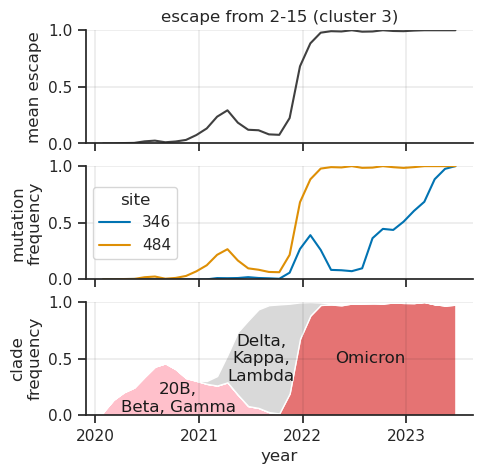

In [47]:
# Plot data
(antibody, cluster) = ('BD56-1797', 7)
(antibody, cluster) = ('BD57-037', 7)
(antibody, cluster) = ('BD-623', 9)
(antibody, cluster) = ('BD55-1962', 2)
(antibody, cluster) = ('2-15', 3)
print(antibody)
(fig, axs) = plt.subplots(
    nrows=3, sharex=True, sharey=True,
    figsize=[5,5]
)

# Plot changes in escape score over time
data = traj_df[traj_df['antibody'] == antibody].copy()
sns.lineplot(
    x='year', y='mean_escape', data=data, ax=axs[0], c='0.25'
)
axs[0].set(
    ylabel=f'mean escape', ylim=[0,1],
    title=f'escape from {antibody} (cluster {cluster})'
)

# Plot changes in mutation frequency
sites_to_plot = escape_mut_corr_df[
    (escape_mut_corr_df['r'] > 0.5) &
    (escape_mut_corr_df['max_freq'] > 0.3) &
    (escape_mut_corr_df['site_escape'] > 0.5) &
    (escape_mut_corr_df['antibody'] == antibody)
]['site']
sites_to_plot = list(map(str, sites_to_plot))
if antibody == '2-15':
    sites_to_plot = [site for site in sites_to_plot if site not in ['490']]
if antibody == 'BD56-1797':
    sites_to_plot = [site for site in sites_to_plot if site not in ['445']]
if antibody == 'BD55-1962':
    sites_to_plot = [site for site in sites_to_plot if site not in ['484']]

data = mut_freq_df.copy()
data['site'] = data['site'].astype(str)
data = data[data['site'].isin(sites_to_plot)]
sns.lineplot(
    x='year', y='mut_freq', data=data, hue='site', ax=axs[1],
)
axs[1].set(ylabel='mutation\nfrequency')
axs[1].legend(loc='center left', title='site')

# Plot clade frequency
clade_freqs_df.sort_values('year', inplace=True)
dfs = []
for params in clade_plotting_params[cluster]:
    (group_name, clade_strs, text_x, text_y, text_c) = params
    data = clade_freqs_df[
        clade_freqs_df['clade'].isin(clade_strs)
    ].copy()
    if len(data) == 0:
        continue
    data = data.groupby('year').sum(numeric_only=True)
    data['clade'] = group_name
    if group_name == '':
        data['freq'] = 0
    dfs.append(data)
    axs[2].text(
        text_x, text_y, group_name, c=text_c,
        ha='center', va='center'
    )

clade_group_colors = ['pink', '#E57373', '0.85']
if len(dfs) == 1:
    print('here')
    axs[2].stackplot(
        dfs[0].index, dfs[0]['freq'],
        colors=['pink'],
        baseline='zero', zorder=0, #alpha=0.5
    )
else:
    axs[2].stackplot(
        dfs[0].index, dfs[0]['freq'], dfs[1]['freq'], dfs[2]['freq'],
        colors=clade_group_colors,
        baseline='zero', zorder=0, #alpha=0.5
    )
axs[2].set(
    xlabel='year', ylabel='clade\nfrequency',
    xticks=[2020, 2021, 2022, 2023]
)
#axs[1].get_legend(bbox_to_anchor=(1,1))
for i in range(3):
    axs[i].grid(linewidth=0.1, c='k')

sns.despine()
plt.show()

Analyze the per-clade fitness and frequency of each mutation

In [48]:
import matplotlib.patches as patches

['L452R', 'L452Q']


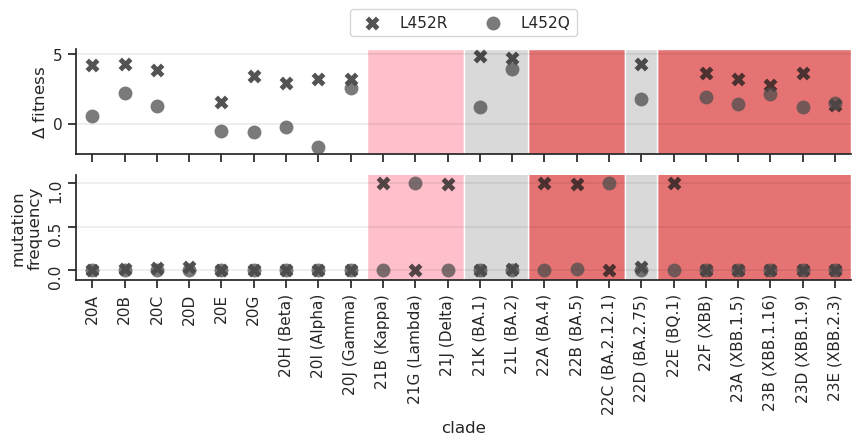

In [50]:
(cluster, muts) = (2, ['L452R', 'L452Q']) # (3, ['K417N', 'K417T']) # (3, ['E484K', 'E484A']) # (7, ['G446S']) # (9, ['F486V', 'F486P', 'F486S']) # (7, ['R346T', 'R346K']) # ['R408S'] # ['T376A'] # ['R408S'] # ['S375F'] # ['T478K', 'T478R'] # 
markers = ['X', 'o', '^']
colors = ['0.1', '0.3', '0.4']
print(muts)
max_clade_freq_df = clade_freqs_df.groupby('clade', as_index=False)['freq'].max()
freq_cutoff = 0.025
passing_clades = list(max_clade_freq_df[max_clade_freq_df['freq'] > freq_cutoff]['clade'])
clades_to_ignore = [
    'recombinant', '19A', '19B', '21A (Delta)', '21I (Delta)',
]
clades_to_plot = [
    clade for clade in sorted(list(clade_freqs_df['clade'].unique()))
    if ((clade not in clades_to_ignore) and (clade in passing_clades)) or (clade in ['21G (Lambda)'])
]

clade_mut_freq_dict = defaultdict(list)
dfs = []
for (clade, data) in escape_scores_df.groupby('clade'):
    for mut in muts:
        data = data.drop_duplicates('strain').copy()
        clade_mut_freq_dict['clade'].append(clade)
        clade_mut_freq_dict['aa_mutation'].append(mut)
        clade_mut_freq_dict['mut_freq'].append(
            sum(data['all_aa_substitutions'].str.contains(mut)) / len(data)
        )
data = pd.DataFrame(clade_mut_freq_dict)
#data['clade'] = data['clade'].apply(lambda x: x[:3])
data = data[
    (data['clade'].isin(clades_to_plot))
]

fitness_data = fitness_df[
    (fitness_df['gene'] == 'S') &
    (fitness_df['clade'].isin(clades_to_plot)) &
    (fitness_df['aa_mutation'].isin(muts))
].copy()
data.sort_values('clade', inplace=True)
fitness_data.sort_values('clade', inplace=True)

# Plot data
(fig, axs) = plt.subplots(nrows=2, sharex=True, figsize=[10,3])

min_fitness = min(-0.5, fitness_data['delta_fitness'].min() - 0.5)
max_fitness = fitness_data['delta_fitness'].max() + 0.5

for (i, mut) in enumerate(muts):
    sns.stripplot(
        x='clade', y='delta_fitness', data=fitness_data[fitness_data['aa_mutation']==mut],
        ax=axs[0],
        order=clades_to_plot, #hue='aa_mutation', hue_order=muts, palette='dark:k',
        s=10, alpha=0.75, dodge=False, marker=markers[i], color=colors[i], label=mut
    )
    sns.stripplot(
        x='clade', y='mut_freq', data=data[data['aa_mutation']==mut],
        ax=axs[1],
        order=clades_to_plot, #hue='aa_mutation', hue_order=muts, palette='dark:k',
        s=10, alpha=0.75, jitter=False, marker=markers[i], color=colors[i]
    )

# Add shaded rectangles
for (clade_params, facecolor) in zip(clade_plotting_params[cluster], clade_group_colors):
    clades = clade_params[1]
    if len(clades) == 0:
        continue
    rectangle_params = []
    x_start = None
    last_clade_index = -100 # arbitrary large negative number
    for clade in clades:
        if clade not in clades_to_plot:
            continue
        clade_index = clades_to_plot.index(clade)
        if x_start == None:
            x_start = clade_index - 0.5
            last_clade_index = clade_index
        elif clade_index == (last_clade_index + 1):
            last_clade_index = clade_index
        else:
            rectangle_params.append((x_start, last_clade_index - x_start + 0.5))
            x_start = clade_index - 0.5
            last_clade_index = clade_index
    rectangle_params.append((x_start, last_clade_index - x_start + 0.5))
    for (x_start, width) in rectangle_params:
        rect = patches.Rectangle((x_start, min_fitness), width, max_fitness+abs(min_fitness), linewidth=1, facecolor=facecolor, zorder=0)
        axs[0].add_patch(rect)
        rect = patches.Rectangle((x_start, -0.2), width, 1.5, linewidth=1, facecolor=facecolor, zorder=0)
        axs[1].add_patch(rect)

# Tweak plot
# if len(muts) == 1:
#     axs[0].get_legend().remove()
#axs[1].get_legend().remove()
axs[0].grid(axis='y', linewidth=0.1, c='k')
axs[1].grid(axis='y', linewidth=0.1, c='k')
axs[0].set(
    ylabel=r'$\Delta$ fitness',
    ylim=[min_fitness, max_fitness]
)
axs[1].set(
    ylabel='mutation\nfrequency',
    ylim=[-0.12, 1.1]
)
axs[1].tick_params(labelrotation=90)
#plt.suptitle('/'.join(muts))
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0].legend(
    by_label.values(), by_label.keys(),
    loc='upper center', ncols=len(muts),
    bbox_to_anchor=(0., 1.35, 1., .102)
)
sns.despine()
plt.show()

Observations
* B38 from group A
    * alpha has the N501Y escape mutation (escape score of 0.27)
    * beta and gamma have the K417N, E484K, and N501Y escape mutations
    * delta lacks  these mutations
    * omicron has the K417N, E484A, N501Y escape mutations
    * the above mutations spike and dip at the same time as the average-escape plot
* 2-15 from group C
    * same as above, but for the 484 mutation?

* BD-623 from group B
    * escape at 486

* 1-57 from group D1
    * escape patterns track with mutations at 446 (G446S?)
    * BA.1 has this mutation, BA.2 does not, but then it occurs later on in omicron evolution    
* BD55-1962 from group D1
    * escape at 452
    
* BD55-1036 from group D2
    * escape at 445
* BD55-1104 from group D2
    * escape at 444, 445, 446
    
* BD55-1245 from group E1
    * escape at 371, 373
    
* BD-713 from group E2.1
    * escape at 346, 452, 484
    * accumulation of multiple partial-escape mutations
* BD-744 from group E2.1
    * escape at 346, 452
    * interesting tradeoff between mutations
* BD55-1312 from group E2.1
    * escape at 484, 490
    * accumulation of multiple partial-escape mutations
* BD-901 from group E2.1
    * escape at 346, 376, 490
    * accumulation of multiple partial-escape mutations
    
* ADG-2 from group F3
    * escape at 408 with partial escape at 484, 505
* BD55-5259 from group F3
    * partial escape at 375, 505
* BD55-5448 from group F3
    * partial escape at many sites: 405, 408, 484, 496, 501, 505